In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
params = np.load("./params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A, plasticity_rule = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A'], params['plasticity_rule']

In [4]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')
d2 = Population(N=N[2], tau=1e-2, phi=phi, name='d2')

J = set_connectivity([ctx, d1, d2], cp, cw, A, plasticity_rule, patterns, plasticity)
network = RateNetwork([ctx, d1, d2], J, formulation=5, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from ctx to d2
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1
INFO:connectivity:Building connections from d1 to d2
INFO:connectivity:Building connections from d2 to ctx
INFO:connectivity:Building connections from d2 to d1
INFO:connectivity:Building connections from d2 to d2


In [5]:
# init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
# init_input_d1 = np.random.RandomState().normal(0,1,size=patterns_d1[0][0].shape)

# init_input_ctx = phi(patterns_ctx[0][0])
# init_input_d1 = phi(patterns_d1[0][1])
# init_input_d2 = np.random.RandomState().normal(0,1,size=patterns_d1[0][0].shape)
init_inputs = [np.zeros(ctx.size),
               np.zeros(d1.size),
               np.zeros(d2.size)]
input_patterns = [p[0] for p in patterns]

T=5 #ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_inputs, input_patterns, plasticity, 
                          delta_t=500, eta=0.0005, tau_e=1600, lamb=0.5, 
                          noise=[.15, 0.05, 0.05], etrace=False, hyper=False,
                          r_ext=[lambda t:0, lambda t:1, lambda t:1], print_output=False)

INFO:network:Integrating network dynamics
100%|█████████▉| 4988/4999 [00:20<00:00, 284.17it/s]

In [6]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
overlaps_d2 = sequences[2][0].overlaps(network.pops[2])
# filename = 'learning-0005-1600-600-5-1000-v0'
# np.savez('./data/' + filename + '.npz', 
#          overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg, 
#          correlations_ctx=correlations_ctx, correlations_bg=correlations_bg, 
#          state_ctx=net_ctx.exc.state, state_bg=net_bg.exc.state)

INFO:sequences:Computing overlaps

100%|██████████| 3/3 [00:00<00:00, 270.98it/s]
INFO:sequences:Computing overlaps

100%|██████████| 3/3 [00:00<00:00, 298.53it/s]
INFO:sequences:Computing overlaps

100%|██████████| 3/3 [00:00<00:00, 278.08it/s]


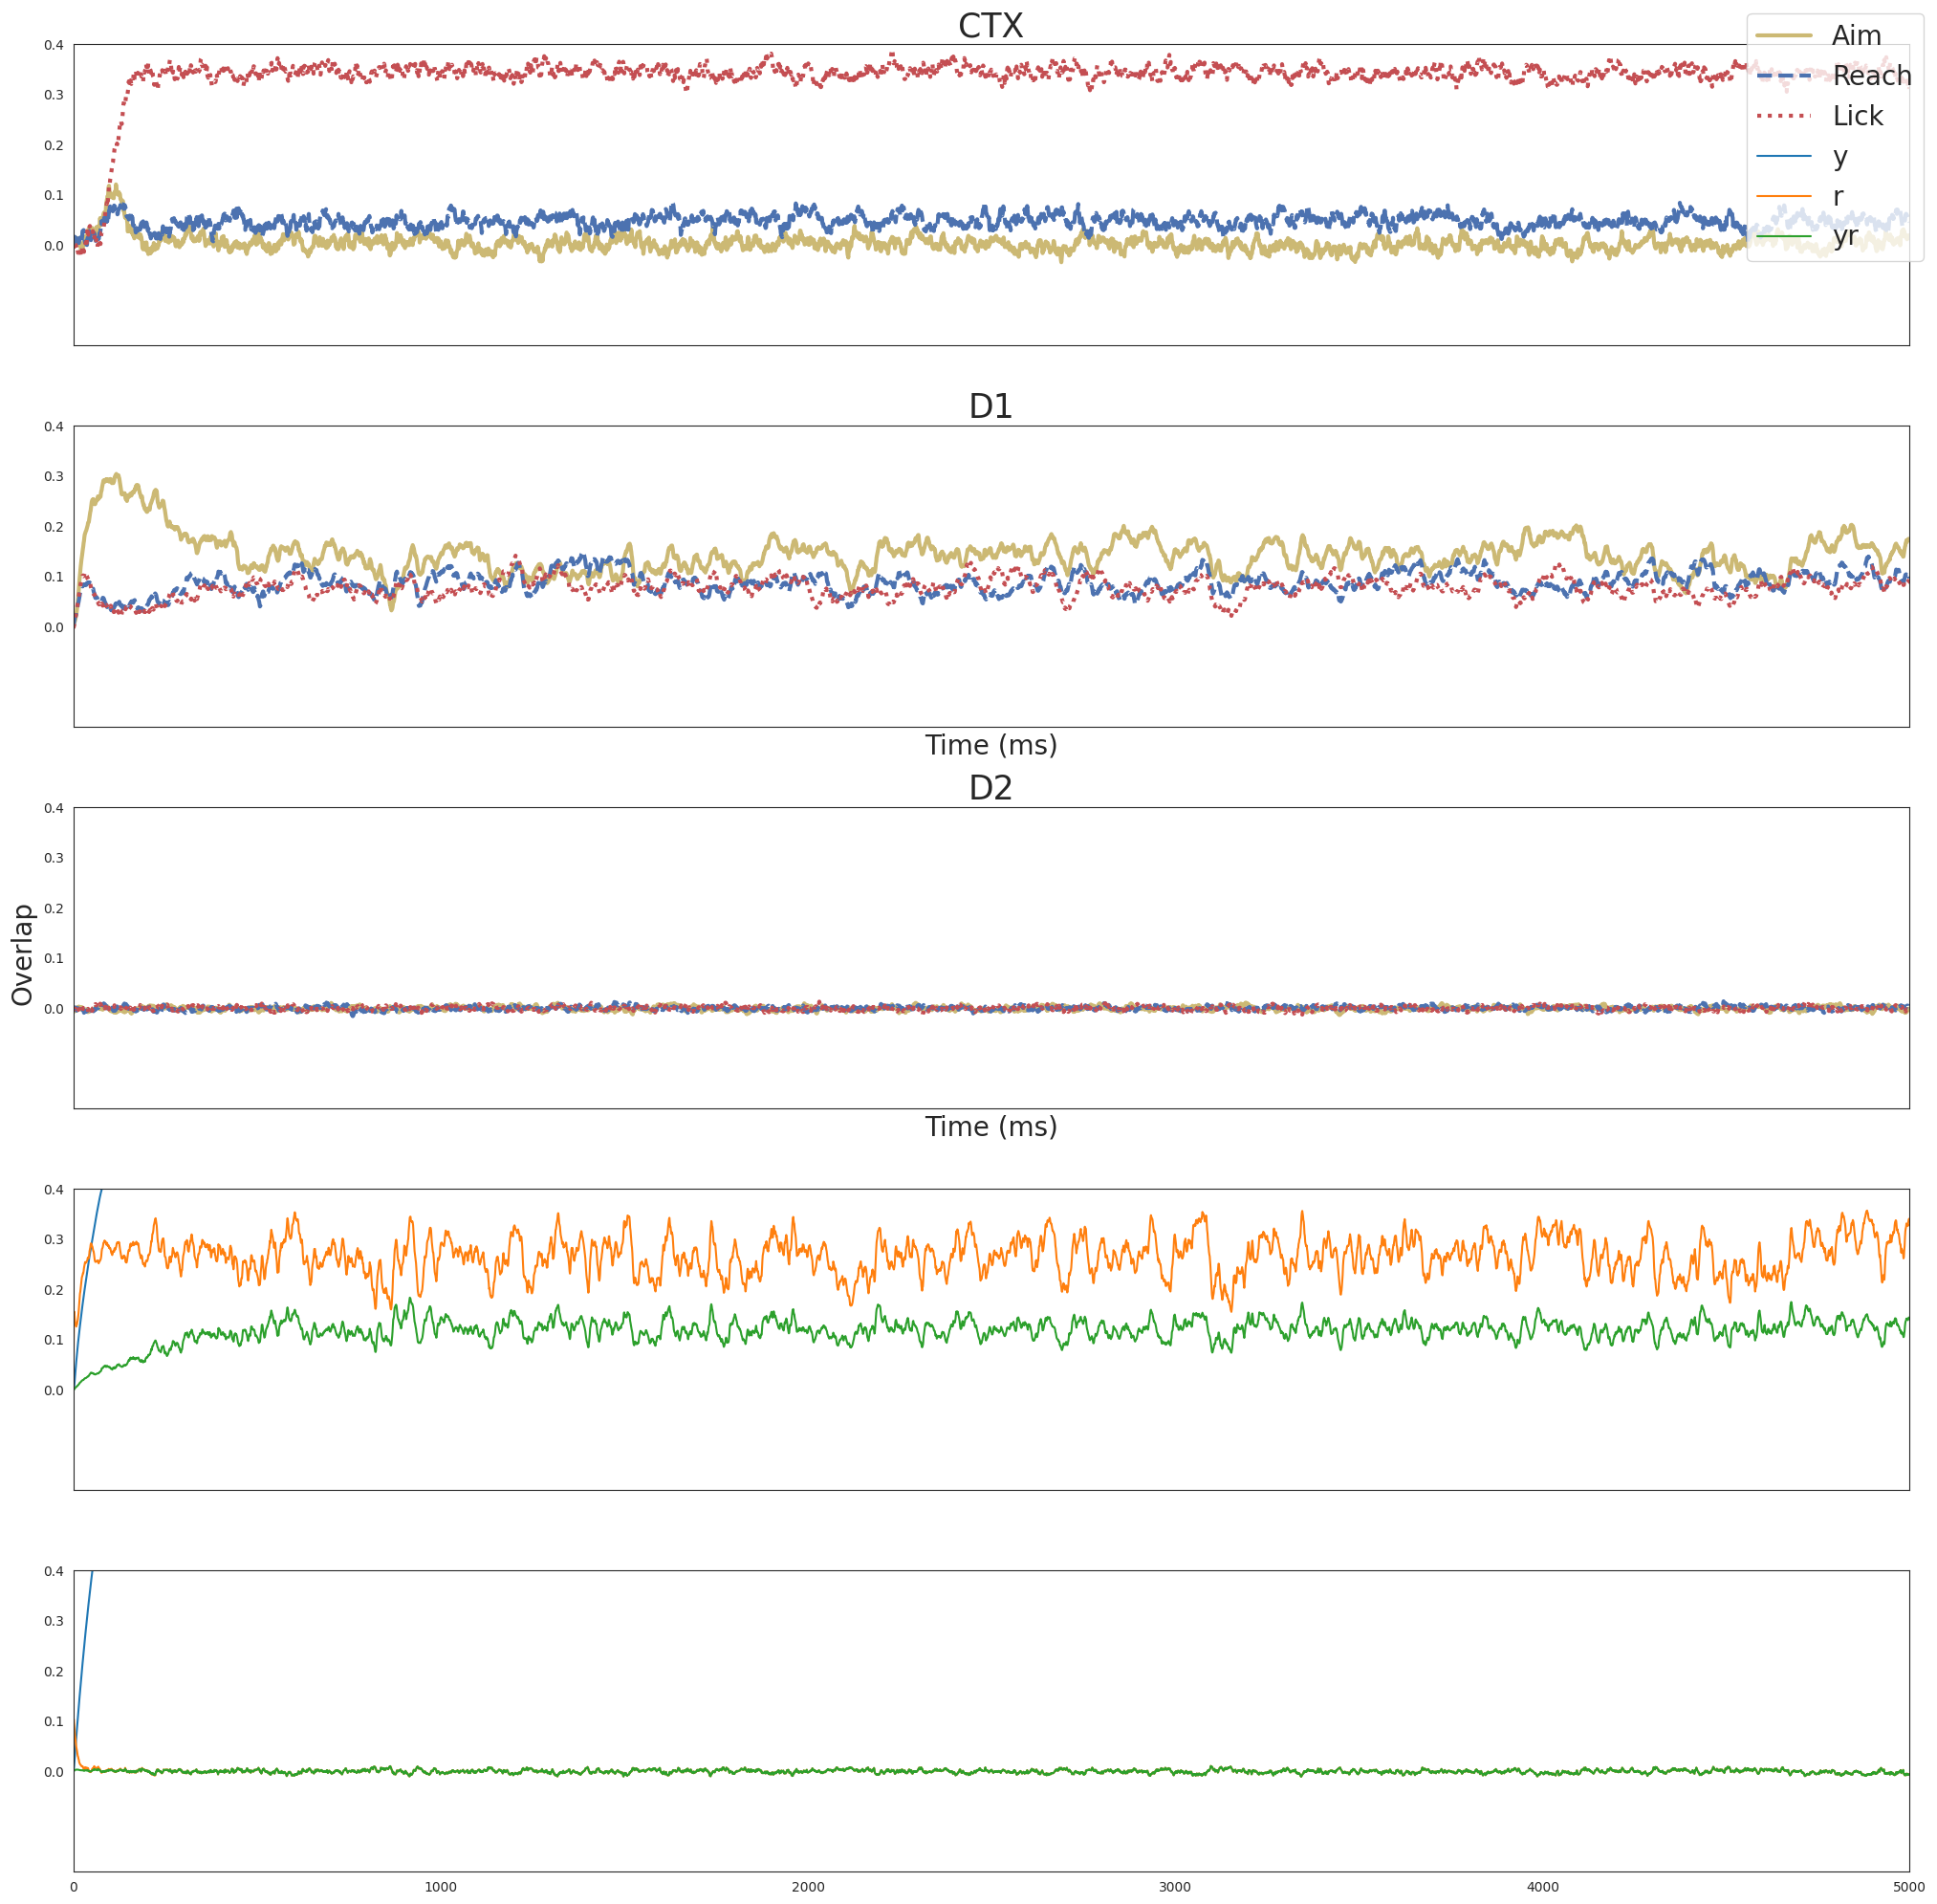

In [8]:
sns.set_style('white') 
colors = sns.color_palette('deep')

fig, axes = plt.subplots(5,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,20))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[2].plot(overlaps_d2[0], linestyle='solid', linewidth=3, color=colors[8])
axes[2].plot(overlaps_d2[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[2].plot(overlaps_d2[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[2].set_title("D2", fontsize=25)
axes[2].set_xlabel('Time (ms)', fontsize=20)
axes[3].plot(np.average(network.pops[1].depression, axis=0), label='y')
axes[3].plot(np.average(network.pops[1].state, axis=0), label='r')
axes[3].plot(np.average(network.pops[1].depression * network.pops[1].state, axis=0), label='yr')
axes[4].plot(np.average(network.pops[2].depression, axis=0))
axes[4].plot(np.average(network.pops[2].state, axis=0))
axes[4].plot(np.average(network.pops[2].depression * network.pops[2].state, axis=0))
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 5000))
plt.setp(axes, ylim=(-.2, .4))
plt.figlegend(fontsize=20)
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/STD-noise.jpg', bbox_inches = "tight", format='jpg')

plt.show()
